## Импорты

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import os
from tqdm import tqdm_notebook, trange, tqdm
import pickle
import numpy as np
from IPython.display import clear_output
import time
import string

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [3]:
device

device(type='cuda', index=0)

In [0]:
# !pip install telepyth -q

# from telepyth import TelepythClient

# tp = TelepythClient("14890519403566776828")

# Предобработка

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
base_path = '/content/drive/My Drive/vkr'
# base_path = '.'

- брать код из обычных репозиториев, а разбивку — из нормализованных
- сначала делаем выборку максимально без изворотов:
    - каждый файл нарезаем на части по n символов в каждом, если в последнем куске не n — выбрасываем
    - сохраняем выборку в файл pickle, пример: `[["import pickl",1], ...]` (потому что дальше идет "е", вероятно)
- преобразовать в удобный для модели формат:
    - вместо строк — массив чисел, где каждое число биективно соответствует символу
    
- модель учится предсказывать n+1 символ, если он eng letter, то это 1, иначе 0

In [0]:
# class PreprocessDataset():
#     def __init__(
#         self,
#         n,
#         path_to_filenames,
#         path_to_repo,
#         objects_limit,
#         check_if_english=True
#     ):
#         self.n = n
#         self.total_count = 0
#         self.pos_count = 0
#         with open(path_to_filenames, 'r') as f:
#             self.filenames = f.read().split('\n')
#         self.path_to_repo = path_to_repo
#         self.dataset_dictionary = set()
#         self.objects_limit = objects_limit
#         self.check_if_english = check_if_english
#         self.allowed_letters = set(string.printable)

#     def update_dataset_dictionary(self, code):
#         self.dataset_dictionary.update(set(code))
        
#     def is_english(self, code):
#         for char in code:
#             if char not in self.allowed_letters:
#                 return False
#         return True

#     def process_code(self, code):
#         self.update_dataset_dictionary(code)
#         chunks, chunk_size = len(code), self.n
#         slices = [code[i:i+chunk_size] for i in range(0, chunks, chunk_size)]
#         self.total_count += len(slices) - 1
#         targets = []
#         for i in range(len(slices) - 1):
#             if slices[i+1][0].isalpha():
#                 self.pos_count += 1
#                 targets.append(True)
#             else:
#                 targets.append(False)
#         slices = slices[:-1]
#         objects_from_code = list(zip(slices, targets))
#         return objects_from_code
        
#     def make_dataset(self):
#         fidx = 0
#         pbar = tqdm(total=self.objects_limit)
#         objects_from_code = []
#         while self.total_count < self.objects_limit:
#             with open(
#                 self.path_to_repo + self.filenames[fidx],
#                 'r'
#             ) as code_file:
#                 code = code_file.read()
#             fidx += 1
#             if self.check_if_english and not self.is_english(code):
#                 continue
#             objects_from_code += self.process_code(code)
#             pbar.update(self.total_count)
#         pbar.close()
# #         print(objects_from_code)

#         print('Number of positives samples is {} out of {} ({:.2f}%)'.format(
#             self.pos_count,
#             self.total_count,
#             100. * self.pos_count / self.total_count
#         ))
        
# #         print(len(self.dataset_dictionary), self.dataset_dictionary)
        
#         return objects_from_code


In [0]:
# prep_dataset = PreprocessDataset(
#     20,
#     base_path + '/pycodesuggest_py_repos_normalised/train_files.txt',
#     base_path + '/pycodesuggest_py_repos_normalised/',
#     objects_limit=5000000
# )
# objects_from_code = prep_dataset.make_dataset()


In [0]:
# objects_from_code[:10]

In [0]:
# prep_dataset.dataset_dictionary

In [0]:
with open(base_path + '/objects_from_code.pickle', 'rb') as f:
    objects_from_code = pickle.load(f)


In [0]:
with open(base_path + '/objects_from_code_test.pickle', 'rb') as f:
    objects_from_code_test = pickle.load(f)


In [0]:
tokens = set(['\t', '\n', '\x0c', ' ', '!', '"', '#', '$', '%', '&', "'",
             '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3',
             '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?',
             '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
             'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c',
             'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o',
             'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{',
             '|', '}', '~']
         )
tok2id = dict(zip(tokens, range(len(tokens))))
id2tok = dict(list(map(lambda x: x[::-1], list(tok2id.items()))))

In [0]:
# tok2id

In [0]:
def convert_for_model(code_samples):
    max_len = len(code_samples[0][0])
    converted_code = np.zeros([len(code_samples), max_len], np.int64)

    for i in range(len(code_samples)):
        obj = list(map(tok2id.get, code_samples[i][0]))
        converted_code[i, :] = obj
    targets = np.array(list(map(lambda pair: pair[1], code_samples)), np.bool)

    return converted_code, targets

In [13]:
%%time
X_train, y_train = convert_for_model(objects_from_code)

CPU times: user 20.5 s, sys: 269 ms, total: 20.7 s
Wall time: 21.1 s


In [14]:
%%time
X_test, y_test = convert_for_model(objects_from_code_test)

CPU times: user 8.08 s, sys: 114 ms, total: 8.2 s
Wall time: 8.21 s


In [0]:
class PredictionNeedCheckerRNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        hidden_size,
        batch_size,
        n_layers=1
    ):
        super(PredictionNeedCheckerRNN, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.emb = nn.Embedding(self.vocab_size, self.hidden_size)
        self.batch_size = batch_size
        self.lstm = torch.nn.LSTM(self.hidden_size, self.hidden_size, self.n_layers)
        self.lin = nn.Linear(self.hidden_size, 1)
        self.act = nn.Sigmoid()
        
    def forward(self, inputs):
        hidden = self.init_hidden()
        for i in range(inputs.shape[1]):
            embs = self.emb(inputs[:, i])
#             print('embs', embs.shape)
#             print('embs', embs.view(1, inputs.size(0), -1).shape)
            _, hidden = self.lstm(embs.view(1, inputs.size(0), -1), hidden)
        output = self.lin(hidden[0])
        output = self.act(output)
        return output.view(inputs.shape[0], -1)#, hidden

    def init_hidden(self):
        return (torch.zeros(
                    self.n_layers,
                    self.batch_size,
                    self.hidden_size,
                    requires_grad=True
                ).to(device),
                torch.zeros(
                    self.n_layers,
                    self.batch_size,
                    self.hidden_size,
                    requires_grad=True
                ).to(device))


In [0]:
vocab_size = len(id2tok)
hidden_size = 50
batch_size = 512

model = PredictionNeedCheckerRNN(vocab_size, hidden_size, batch_size).to(device)
# hidden = model.init_hidden()
# inputs = torch.from_numpy(X_train[:batch_size])
# model.forward(inputs)

In [0]:
def train_epoch(model, optimizer, train_batches, target_batches):
    loss_log = []
    model.train()
    
    correct = 0
    total = 0
    for batch, target in tqdm_notebook(list(zip(train_batches, target_batches))):
#         <your code>
        loss_func = nn.BCELoss()
        tensor = torch.from_numpy(batch).to(device)
        output = model.forward(tensor)
        probs = np.squeeze(output.cpu().detach().numpy())
        probs = np.where(probs > 0.5, 1, 0)
#         print(probs.shape)
#         print(target.shape)
#         print((probs == target).shape)
        correct += (probs == target).sum()
        total += target.shape[0]
#         print('target', total, correct)
        loss = loss_func(output, torch.Tensor(np.array(target, dtype=np.uint8)).to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()
        loss_log.append(loss)
    return loss_log, correct, total

def test(model):
    loss_log = []
    model.eval()
    
    correct = 0
    total = 0
    limit = len(X_test) // batch_size * batch_size
    test_batches, target_batches = X_test[:limit], y_test[:limit]
    test_batches = np.split(test_batches, len(test_batches) // batch_size)
    target_batches = np.split(target_batches, len(target_batches) // batch_size)
    for batch, target in tqdm_notebook(list(zip(test_batches, target_batches))):
        tensor = torch.from_numpy(batch).to(device)
        output = model.forward(tensor)
        probs = np.squeeze(output.cpu().detach().numpy())
        probs = np.where(probs > 0.5, 1, 0)
        correct += (probs == target).sum()
        total += target.shape[0]
    print('Accuracy on test dataset = {} / {} = {:.3f}'.format(
        correct, total, correct / total
    ))

# def plot_history(train_history, val_history, title='loss'):
def plot_history(train_history, title='Потери'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='Обучающая выборка', zorder=1)    
#     points = np.array(val_history)
#     plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('Шаги обучения')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    
    total_steps = 0
    limit = len(X_train) // batch_size * batch_size
    train_batches, target_batches = X_train[:limit], y_train[:limit]
    train_batches = np.split(train_batches, len(train_batches) // batch_size)
    target_batches = np.split(target_batches, len(target_batches) // batch_size)
#     test_batches = np.split(val_data, len(val_data) // batch_size)
    for epoch in range(n_epochs):
        train_loss, correct, total = train_epoch(model, opt, train_batches, target_batches)
        train_log.extend(train_loss)
#         total_steps += len(train_batches)
        
#         val_loss = test(model, test_batches)
#         train_log.extend(train_loss)
        
#         val_log.append((len(train_log), np.mean(val_loss)))
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': train_log[-1]
            },
            base_path + '/char_rnn_checkpoints/checkpoint_{}.pt'.format(epoch)
        )
        
        clear_output()
        print('Epoch {}'.format(epoch))
        print('Accuracy = {} / {} = {:.2f}'.format(correct, total, correct / total))
        plot_history(train_log)#, val_log)


Epoch 3
Accuracy = 4655918 / 5001728 = 0.93


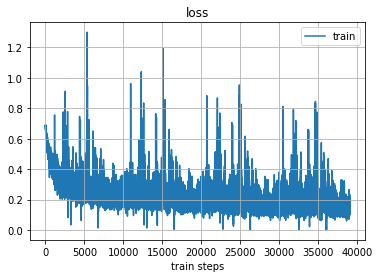

CPU times: user 9min 57s, sys: 33.4 s, total: 10min 31s
Wall time: 10min 34s


In [32]:
%%time

opt = torch.optim.Adam(model.parameters(), lr=1e-4)
train(model, opt, 4)

In [39]:
test(model)


Accuracy on test dataset = 1813737 / 1999872 = 0.907


# Примеры работы

In [0]:
convert_for_model(objects_from_code[:1])[0].tolist()[0]

[38, 10, 16, 46, 50, 26, 86, 89, 70, 46, 47, 9, 38, 10, 16, 46, 50, 26, 86, 46]

In [0]:
list(map(id2tok.get, convert_for_model(objects_from_code[:1])[0].tolist()[0]))

['i',
 'm',
 'p',
 'o',
 'r',
 't',
 ' ',
 'j',
 's',
 'o',
 'n',
 '\n',
 'i',
 'm',
 'p',
 'o',
 'r',
 't',
 ' ',
 'o']